# FOR THIS  TEST N=16

In [1]:
#https://github.com/mathybit/ml-tutorials/blob/master/adversarial_neural_cryptography.ipynb
#https://github.com/mila-iqia/ivado-mila-dl-school-2019/tree/master/tutorials
#https://github.com/tyburam/neural-cryptography-pytorch/blob/master/src/model.py

# Define The Parameters

In [12]:

KEY_TEXT=4
MSG_TEXT=4
C_TEXT=4
LEARNING_RATE=0.1
LAMBDA=5
BATCH_SIZE=512
m_train=2**(MSG_TEXT)
NUM_BATCH_SIZE=128
MAX_INTERATION=100000
EVE_ONE_BIT_WRONG_THRESH = 0.97
BOB_ONE_BIT_WRONG_THRESH=0.0025
CLIP_VALUE = 1
LOOPS_PER_PRINT = 100   # every 100 loops print one time
CYCLE_ALICE_BOB=5
CYCLE_EVE=10


In [13]:
m_train/256

0.0625

# PACKAGE USED IN OUR TEST

In [14]:
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim

import seaborn as sns
import matplotlib.pyplot as plt
import time

# We define the function we want to use to transforme 

In [15]:
def function(x):
  return torch.acos((1-2*x))
  ''' ''' 

def inv_function(y):
    
  return (1-torch.cos(y))/2

# We define Our Networks for Alice and Bob

In [16]:
class Network(nn.Module):
    '''
    Standard Convolutional layers setup used by Alice and Bob.
    Input: 2N tensor, PlainText+MessageKey(Alice) or CipherText+Key(Bob)
    Output: N tensor, CipherText(Alice) or PlainText(Bob)
    '''
    def __init__(self):
        super(Network,self).__init__()
        self.fc_in =MSG_TEXT + KEY_TEXT
        self.fc_out = KEY_TEXT
        self.l1 = nn.Linear(self.fc_in,self.fc_out,bias=False)

    def forward(self,input):

        inputs = function(input)
        #print("inputs:",inputs)
        out = self.l1(inputs) #requires_grad
        #print("out:",out.requires_grad)
        _out = inv_function(out) #possibly removes requires grad
        #print("_out:",_out.requires_grad)
        #print("out:",_out)
        
        output = _out
        #print('one pass AB', output.size())
        return output


# EVE NETWORK


In [17]:
class Network2(nn.Module):
    '''
    Standard Convolutional layers setup used by Alice and Bob.
    Input: 2N tensor, PlainText+MessageKey(Alice) or CipherText+Key(Bob)
    Output: N tensor, CipherText(Alice) or PlainText(Bob)
    '''
    def __init__(self):
        super(Network2,self).__init__()
        self.fc_in =MSG_TEXT
        self.fc_out = C_TEXT
        self.l1 = nn.Linear(self.fc_in,self.fc_out,bias=False)

    def forward(self,input):

        inputs = function(input)
        #print("inputs:",inputs)
        out = self.l1(inputs) #requires_grad
        #print("out:",out.requires_grad)
        _out = inv_function(out) #possibly removes requires grad
        #print("_out:",_out.requires_grad)
        #print("out:",_out)
        
        output = _out
        #print('one pass AB', output.size())
        return output


# Function to GEnerate DATA and Plot

In [18]:
def generate_data(batch_size, ptext_size, key_size):
    """
    generate data.
    :param batch_size: batch size, hyper-parameters, in this program BATCH_SIZE is 256
    :param ptext_size: ptext size, hyper-parameters, in this program PTEXT_SIZE is 16
    :param key_size: key's size, hyper-parameters, in this program KEY_SIZE is 16
    :return: ptext and key, in this program size are both [256, 16]
    """
    ptext = torch.randint(0, 2, (batch_size, ptext_size), dtype=torch.float) * 1
    key = torch.randint(0, 2, (batch_size, key_size), dtype=torch.float) * 1
    return ptext, key

In [19]:
def gen_data(n=BATCH_SIZE, msg_len=MSG_TEXT, key_len=KEY_TEXT):
    return (np.random.randint(0, 2, size=(n, msg_len)) * 1), \
           (np.random.randint(0, 2, size=(n, key_len)) * 1)

In [20]:
#msg,key=generate_data(512,16,16)

In [21]:
def plot_wrong( alice_bob_wrong_for_plot,eve_wrong_for_plot):
    """
    plot epoch-wrong picture
    
    :param alice_bob_wrong_for_plot: a list, element is the mean of bob one bit wrong
    :return:
    """
    plt.plot(range(1, len(eve_wrong_for_plot)+1), eve_wrong_for_plot, label='eve one bit wrong mean')
    plt.plot(range(1, len(alice_bob_wrong_for_plot)+1), alice_bob_wrong_for_plot, label='bob one bit wrong mean')
    plt.xlabel("Epochs")
    plt.ylabel("One Bit Wrong")
    plt.title("optimizer_alice_bob_times")
    plt.legend()
    plt.show()


def plot_errors(eve_errors,alice_bob_loss):
  sns.set_style("darkgrid")
  #plt.plot(bob_errors)
  plt.plot(eve_errors)
  plt.plot(alice_bob_loss)
  plt.legend(['bob', 'eve','alice bob'])
  plt.xlabel('Epoch')
  plt.ylabel('Lowest Decryption error achieved')
  plt.show()



In [545]:
def train():
   bob_errors = []
   eve_errors = []
   alice_bob_los=[]
   #torch.manual_seed(10)
   alice_bob = Network()
   eve = Network2()
   alice_bob.train()
   eve.train()

   optimizer_alice_bob = optim.Adam(alice_bob.parameters(), lr=LEARNING_RATE)
   optimizer_eve = optim.Adam(eve.parameters(), lr=LEARNING_RATE)


   alice_bob_reconstruction_error = nn.L1Loss()
   eve_reconstruction_error = nn.L1Loss()



   for i in range(20):
      err_bob = err_eve = 0

      #print('Training networks, Epoch:', i + 1)
      start_time = time.time()

      
      for j in range(128):
        np.random.seed(1)
        data = gen_data(BATCH_SIZE, MSG_TEXT, KEY_TEXT)
        msg = torch.tensor(data[0], dtype=torch.float)
        key = torch.tensor(data[1], dtype=torch.float)
        alice_input = torch.cat((msg, key), 1)
        optimizer_alice_bob.zero_grad()
        optimizer_eve.zero_grad() 

        with torch.no_grad():
          ctext= alice_bob(alice_input)
          
              #print(ptext_eve)
                
        ptext_eve = eve(ctext)
        bob_input = torch.cat((ctext, key), 1)
        ptext_bob = alice_bob(bob_input)

        alice_bob_error=alice_bob_reconstruction_error(ptext_bob,msg)
        eve_error =eve_reconstruction_error(ptext_eve,msg)
          #print(eve_error)
        alice_bob_loss=alice_bob_error -  5*min(eve_error.item(),0.2)

        alice_bob_loss.backward(retain_graph=True)
        optimizer_alice_bob.step()

        
        eve_error.backward()
        optimizer_eve.step()
    
    #print('bob error: {} eve error: {}'.format(alice_bob_error.data, eve_error.data))
      bob_errors.append(alice_bob_error.data)
     
      eve_errors.append(eve_error.data)
      alice_bob_los.append(alice_bob_loss.data)
      checkpoint={'alice_bob':Network(),
                'state_dict': alice_bob.state_dict(),
                'optimizer': optimizer_alice_bob.state_dict()
                }
      torch.save(checkpoint,'checkpoint1.pth')
      checkpoint1={'eve': Network2(),
                'state_dict1': eve.state_dict(),
                'optimizer1': optimizer_eve.state_dict()
                }
      torch.save(checkpoint1,'checkpoint11.pth')
  
   plot_errors(eve_errors,alice_bob_los)

/home/syllamohamed/anaconda3/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Network. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/syllamohamed/anaconda3/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Linear. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/syllamohamed/anaconda3/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Network2. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/syllamohamed/anaconda3/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Linear. It won't be checked for correctness upon loading.
  "type "

/home/syllamohamed/anaconda3/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Network. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/syllamohamed/anaconda3/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Linear. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/syllamohamed/anaconda3/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Network2. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/syllamohamed/anaconda3/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Linear. It won't be checked for correctness upon loading.
  "type "

/home/syllamohamed/anaconda3/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Network. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/syllamohamed/anaconda3/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Linear. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/syllamohamed/anaconda3/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Network2. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/syllamohamed/anaconda3/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Linear. It won't be checked for correctness upon loading.
  "type "

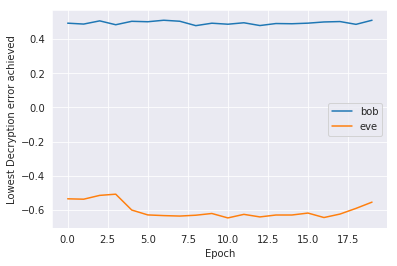

In [546]:
train()

Epoch   0:  99% | abe: -2.108 | eve: 0.477 | bob: 0.392

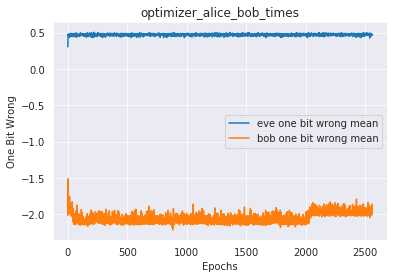

/home/syllamohamed/anaconda3/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Network. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/syllamohamed/anaconda3/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Linear. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/syllamohamed/anaconda3/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Network2. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/syllamohamed/anaconda3/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Linear. It won't be checked for correctness upon loading.
  "type "

In [438]:
import sys
def train():
  torch.manual_seed(10)
  alice_bob_one_bit_wrong_mean = 0.0
  eve_one_bit_wrong_mean =0.0
  #alice_bob = Network()
  alice_bob_wrong_for_plot = []
  eve_wrong_for_plot       = []
  alice_bob = Network()
  eve = Network2()

  alice_bob.train()
  eve.train()

  optimizer_alice_bob = optim.Adam(alice_bob.parameters(), lr=LEARNING_RATE)
  optimizer_eve = optim.Adam(eve.parameters(), lr=LEARNING_RATE)


  alice_bob_reconstruction_error = nn.L1Loss()
  eve_reconstruction_error = nn.L1Loss()

  
  for i in range(60):

    for k in range(128):
        start_time = time.time()
        for network,num_minibatch in {'alice_bob': 5, 'eve': 10}.items():

          for minibatch in range(num_minibatch):
            np.random.seed(1)
            data = gen_data(BATCH_SIZE, MSG_TEXT, KEY_TEXT)
            msg = torch.tensor(data[0], dtype=torch.float)
            key = torch.tensor(data[1], dtype=torch.float)
            alice_input = torch.cat((msg, key), 1)
            with torch.no_grad():
              ctext= alice_bob(alice_input)

              #print(ptext_eve)
            ptext_eve = eve(ctext)

            if network == 'alice_bob':
              bob_input = torch.cat((ctext, key), 1)
              ptext_bob = alice_bob(bob_input)


          #print(ptext_bob)

              alice_bob_error=alice_bob_reconstruction_error(ptext_bob,msg)
              eve_error =eve_reconstruction_error(ptext_eve,msg)
              #print(eve_error)
              optimizer_alice_bob.zero_grad()
              alice_bob_loss=alice_bob_error -  5*min(eve_error.item(),0.5)
              #print(alice_bob_loss)



            #optimizer_alice.zero_grad()
              alice_bob_loss.backward()
              #nn.utils.clip_grad_value_(alice_bob.parameters(), CLIP_VALUE)
            #


            #optimizer_alice.step()
              optimizer_alice_bob.step()
                
            elif network == 'eve':
              optimizer_eve.zero_grad()
              eve_error =eve_reconstruction_error(ptext_eve,msg)
              #print(eve_error)
              eve_error.backward()
              #nn.utils.clip_grad_value_(eve.parameters(), CLIP_VALUE)
              optimizer_eve.step()



        time_elapsed = time.time() - start_time

        bob_one_bit_wrong_mean = alice_bob_loss.cpu().detach().numpy()
        bob_one = alice_bob_error.cpu().detach().numpy()
        eve_one_bit_wrong_mean = eve_error.cpu().detach().numpy()


        if i % LOOPS_PER_PRINT == 0:
          '''print(f'Epoch: {i + 1:06d} | '
                f'one epoch time: {time_elapsed:.3f} | '
                f'bob one bit wrong: {bob_one_bit_wrong_mean:.4f} |'
                f'eve one bit wrong: {eve_one_bit_wrong_mean:.4f}')'''
          print("\rEpoch {:3}: {:3}% | abe: {:2.3f} | eve: {:2.3f} | bob: {:2.3f}".format(
                i, 100 * k // 128, bob_one_bit_wrong_mean, eve_one_bit_wrong_mean, bob_one), end="")
          sys.stdout.flush()
        alice_bob_wrong_for_plot.append(bob_one_bit_wrong_mean)
        eve_wrong_for_plot.append(eve_one_bit_wrong_mean)

  plot_wrong(alice_bob_wrong_for_plot,eve_wrong_for_plot)
  
  checkpoint={'alice_bob':Network(),
                'state_dict': alice_bob.state_dict(),
                'optimizer': optimizer_alice_bob.state_dict()
                }
  torch.save(checkpoint,'checkpoint1.pth')
  checkpoint1={'eve': Network2(),
                'state_dict1': eve.state_dict(),
                'optimizer1': optimizer_eve.state_dict()
                }
  torch.save(checkpoint1,'checkpoint11.pth')




if __name__ == "__main__":

    train()





In [22]:
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    model = checkpoint['alice_bob']
    model.load_state_dict(checkpoint['state_dict'])
    for parameter in model.parameters():
        parameter.requires_grad = False

    model.eval()
    return model

In [23]:
def load_checkpoint1(filepath):
    checkpoint = torch.load(filepath)
    model = checkpoint['eve']
    model.load_state_dict(checkpoint['state_dict1'])
    for parameter in model.parameters():
        parameter.requires_grad = False

    model.eval()
    return model

In [38]:

def validate():
    """
    generate a ptext and key and compare them to the output of the model
    :return:
    """
    fail=0
    count=0
    for i in range(1):

      data = gen_data(BATCH_SIZE, MSG_TEXT, KEY_TEXT)
      msg = torch.tensor(data[0], dtype=torch.float)
      key = torch.tensor(data[1], dtype=torch.float)

      #alice_bob= model_load_checkpoint()
      alice_bob = load_checkpoint('checkpoint1.pth')
      eve = load_checkpoint1('checkpoint11.pth')
      alice_bob.l1.weight=torch.nn.Parameter(alice_bob.l1.weight.round()) #Not rounded off
      eve.l1.weight=torch.nn.Parameter(eve.l1.weight.round()) #Not rounded off
      with torch.no_grad():
        ctext = alice_bob(torch.cat((msg, key), 1))

      with torch.no_grad():
        predict_ptext_bob = alice_bob(torch.cat((ctext, key), 1))
        predict_ptext_eve = eve(ctext)
    

      # for better print
      ptext = msg.cpu().detach().numpy()
      key = key.cpu().detach().numpy()
      predict_ptext_bob = predict_ptext_bob.cpu().detach().numpy()
      predict_ptext_eve = predict_ptext_eve.cpu().detach().numpy()

      print('ciphetext:\n{}\n\n Real ptext:\n{}\n\nptext  key:\n{}\n\nkey'.format(ctext[0],ptext[0],key[0]))
    #print(count,fail) 

    

if __name__ == '__main__':
    validate()

ciphetext:
tensor([0., 0., 0., 1.])

 Real ptext:
[0. 0. 0. 1.]

ptext  key:
[0. 0. 0. 0.]

key
